In [ ]:
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.signal import detrend


def find_peaks_original(x, scale=None, debug=False):
    """Find peaks in quasi-periodic noisy signals using AMPD algorithm.
    Automatic Multi-Scale Peak Detection originally proposed in
    "An Efficient Algorithm for Automatic Peak Detection in
    Noisy Periodic and Quasi-Periodic Signals", Algorithms 2012, 5, 588-603
    https://doi.org/10.1109/ICRERA.2016.7884365
    Optimized implementation by Igor Gotlibovych, 2018
    Parameters
    ----------
    x : ndarray
        1-D array on which to find peaks
    scale : int, optional
        specify maximum scale window size of (2 * scale + 1)
    debug : bool, optional
        if set to True, return the Local Scalogram Matrix, `LSM`,
        and scale with most local maxima, `l`,
        together with peak locations
    Returns
    -------
    pks: ndarray
        The ordered array of peak indices found in `x`
    """
    x = detrend(x)
    N = len(x)
    L = N // 2
    if scale:
        L = min(scale, L)

    # create LSM matix
    LSM = np.zeros((L, N), dtype=bool)
    for k in np.arange(1, L):
        LSM[k - 1, k:N - k] = (
            (x[0:N - 2 * k] < x[k:N - k]) & (x[k:N - k] > x[2 * k:N])
        )

    # Find scale with most maxima
    G = LSM.sum(axis=1)
    l_scale = np.argmax(G)

    # find peaks that persist on all scales up to l
    pks_logical = np.min(LSM[0:l_scale, :], axis=0)
    pks = np.flatnonzero(pks_logical)
    if debug:
        return pks, LSM, l_scale
    return pks


def find_peaks(x, scale=None, debug=False):
    """Find peaks in quasi-periodic noisy signals using AMPD algorithm.
    Extended implementation handles peaks near start/end of the signal.
    Optimized implementation by Igor Gotlibovych, 2018
    Parameters
    ----------
    x : ndarray
        1-D array on which to find peaks
    scale : int, optional
        specify maximum scale window size of (2 * scale + 1)
    debug : bool, optional
        if set to True, return the Local Scalogram Matrix, `LSM`,
        weigted number of maxima, 'G',
        and scale at which G is maximized, `l`,
        together with peak locations
    Returns
    -------
    pks: ndarray
        The ordered array of peak indices found in `x`
    """
    x = detrend(x)
    N = len(x)
    L = N // 2
    if scale:
        L = min(scale, L)

    # create LSM matix
    LSM = np.ones((L, N), dtype=bool)
    for k in np.arange(1, L + 1):
        LSM[k - 1, 0:N - k] &= (x[0:N - k] > x[k:N]
                                )  # compare to right neighbours
        LSM[k - 1, k:N] &= (x[k:N] > x[0:N - k])  # compare to left neighbours

    # Find scale with most maxima
    G = LSM.sum(axis=1)
    G = G * np.arange(
        N // 2, N // 2 - L, -1
    )  # normalize to adjust for new edge regions
    l_scale = np.argmax(G)

    # find peaks that persist on all scales up to l
    pks_logical = np.min(LSM[0:l_scale, :], axis=0)
    pks = np.flatnonzero(pks_logical)
    if debug:
        return pks, LSM, G, l_scale
    return pks


def find_peaks_adaptive(x, window=None, debug=False):
    """Find peaks in quasi-periodic noisy signals using ASS-AMPD algorithm.
    Adaptive Scale Selection Automatic Multi-Scale Peak Detection,
    an extension of AMPD -
    "An Efficient Algorithm for Automatic Peak Detection in
    Noisy Periodic and Quasi-Periodic Signals", Algorithms 2012, 5, 588-603
    https://doi.org/10.1109/ICRERA.2016.7884365
    Optimized implementation by Igor Gotlibovych, 2018
    Parameters
    ----------
    x : ndarray
        1-D array on which to find peaks
    window : int, optional
        sliding window size for adaptive scale selection
    debug : bool, optional
        if set to True, return the Local Scalogram Matrix, `LSM`,
        and `adaptive_scale`,
        together with peak locations
    Returns
    -------
    pks: ndarray
        The ordered array of peak indices found in `x`
    """
    x = detrend(x)
    N = len(x)
    if not window:
        window = N
    if window > N:
        window = N
    L = window // 2

    # create LSM matix
    LSM = np.ones((L, N), dtype=bool)
    for k in np.arange(1, L + 1):
        LSM[k - 1, 0:N - k] &= (x[0:N - k] > x[k:N]
                                )  # compare to right neighbours
        LSM[k - 1, k:N] &= (x[k:N] > x[0:N - k])  # compare to left neighbours

    # Create continuos adaptive LSM
    ass_LSM = uniform_filter1d(LSM * window, window, axis=1, mode='nearest')
    normalization = np.arange(L, 0, -1)  # scale normalization weight
    ass_LSM = ass_LSM * normalization.reshape(-1, 1)

    # Find adaptive scale at each point
    adaptive_scale = ass_LSM.argmax(axis=0)

    # construct reduced LSM
    LSM_reduced = LSM[:adaptive_scale.max(), :]
    mask = (np.indices(LSM_reduced.shape)[0] > adaptive_scale
            )  # these elements are outside scale of interest
    LSM_reduced[mask] = 1

    # find peaks that persist on all scales up to l
    pks_logical = np.min(LSM_reduced, axis=0)
    pks = np.flatnonzero(pks_logical)
    if debug:
        return pks, ass_LSM, adaptive_scale
    return pks

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data as Data
import torchvision.datasets
import torchvision.transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
# from pyampd.ampd import find_peaks


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import matplotlib.pyplot as plt


import joblib

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/archive.zip

Archive:  gdrive/My Drive/archive.zip
  inflating: Samples/rec_1.csv       
  inflating: Samples/rec_10.csv      
  inflating: Samples/rec_100.csv     
  inflating: Samples/rec_101.csv     
  inflating: Samples/rec_102.csv     
  inflating: Samples/rec_103.csv     
  inflating: Samples/rec_104.csv     
  inflating: Samples/rec_105.csv     
  inflating: Samples/rec_106.csv     
  inflating: Samples/rec_107.csv     
  inflating: Samples/rec_108.csv     
  inflating: Samples/rec_109.csv     
  inflating: Samples/rec_11.csv      
  inflating: Samples/rec_110.csv     
  inflating: Samples/rec_111.csv     
  inflating: Samples/rec_112.csv     
  inflating: Samples/rec_113.csv     
  inflating: Samples/rec_114.csv     
  inflating: Samples/rec_115.csv     
  inflating: Samples/rec_116.csv     
  inflating: Samples/rec_117.csv     
  inflating: Samples/rec_118.csv     
  inflating: Samples/rec_119.csv     
  inflating: Samples/rec_12.csv      
  inflating: Samples/rec_120.csv     
  inflating:

In [ ]:
PPG_datas = []
ABP_datas = []
ECG_datas = []
i = 0
for name in glob.glob('./Samples/*.csv'):
    raw_training_data = pd.read_csv(name, header=None)
    raw_training_data = np.array(raw_training_data)
    #print(raw_training_data.shape)
    PPG_data = raw_training_data[0]
    ABP_data = raw_training_data[1]
    ECG_data = raw_training_data[2]

    PPG_datas.append(PPG_data)
    ABP_datas.append(ABP_data)
    ECG_datas.append(ECG_data)
    # i = i + 1
 #   print(i)
#     if (i == 100):
#         break

PPG_datas = np.array(PPG_datas)
ABP_datas = np.array(ABP_datas)
ECG_datas = np.array(ECG_datas)
# raw_training_data.head()

<ipython-input-6-cafb0a523fd7>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  PPG_datas = np.array(PPG_datas)
<ipython-input-6-cafb0a523fd7>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ABP_datas = np.array(ABP_datas)
<ipython-input-6-cafb0a523fd7>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ECG_datas = np.array(ECG_da

In [ ]:
import pywt
from sklearn.decomposition import PCA

def generate_wavelet_vector(X, wavelet_family, decomposition_level):
    coefficients = pywt.wavedec(X, wavelet_family, level=decomposition_level)
    vector = np.array([])
    for coeffs in coefficients:
        vector = np.concatenate((vector, coeffs))
    return vector

In [ ]:
SAMPLE_FREQ = 125

In [ ]:
wavelet_family = 'db4'
decomposition_level = 5

wavelet_vectors = []
SBP_data = []
DBP_data = []
MAP_data = []

for j in range(len(PPG_datas)):
    sec_15 = 15 * SAMPLE_FREQ
    PPG_data = PPG_datas[j]
    ABP_data = ABP_datas[j]
    PPG_peaks = find_peaks(PPG_data, scale=SAMPLE_FREQ)
    for i in range(2, PPG_peaks.shape[0]):
        X = PPG_data[PPG_peaks[i - 1]:PPG_peaks[i]]
        if len(X) < SAMPLE_FREQ:
            wavelet_vector = generate_wavelet_vector(X, wavelet_family, decomposition_level)

            SBP = np.max(ABP_data[PPG_peaks[i - 1]:PPG_peaks[i - 1] + sec_15])
            DBP = np.min(ABP_data[PPG_peaks[i - 1]:PPG_peaks[i - 1] + sec_15])
            MAP = SBP / 3 + 2 * DBP / 3

            wavelet_vectors.append(wavelet_vector)
            SBP_data.append(SBP)
            DBP_data.append(DBP)
            MAP_data.append(MAP)

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [ ]:
wavelet_vectors = np.array(wavelet_vectors)
SBP_data = np.array(SBP_data)
DBP_data = np.array(DBP_data)
MAP_data = np.array(MAP_data)

print(wavelet_vectors.shape)
print(SBP_data.shape)

# Find the maximum length of the wavelet vectors
max_length = max([len(vector) for vector in wavelet_vectors])

# Pad the wavelet vectors with zeros to make them uniform length
padded_wavelet_vectors = []
for vector in wavelet_vectors:
    padded_vector = np.pad(vector, (0, max_length - len(vector)), mode='constant')
    padded_wavelet_vectors.append(padded_vector)

padded_wavelet_vectors = np.array(padded_wavelet_vectors)

<ipython-input-10-6f3e639507bb>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wavelet_vectors = np.array(wavelet_vectors)


(196625,)
(196625,)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=43)
pca_wavelet_vectors = pca.fit_transform(padded_wavelet_vectors)

print(pca_wavelet_vectors.shape)


(196625, 43)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, SBP_train, SBP_test, DBP_train, DBP_test, MAP_train, MAP_test = train_test_split(
    pca_wavelet_vectors, SBP_data, DBP_data, MAP_data, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'wavelet vector after PCA')

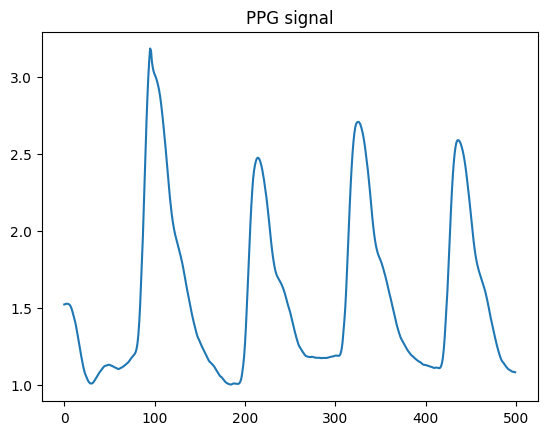

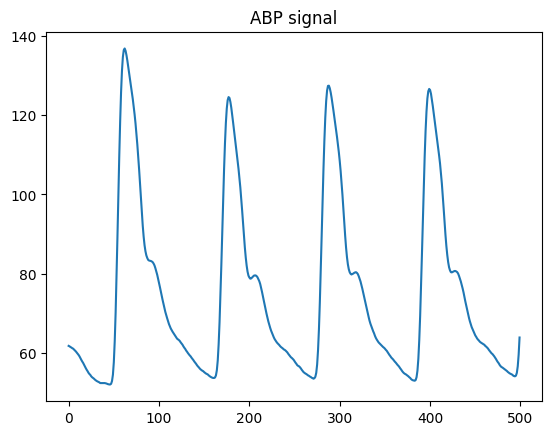

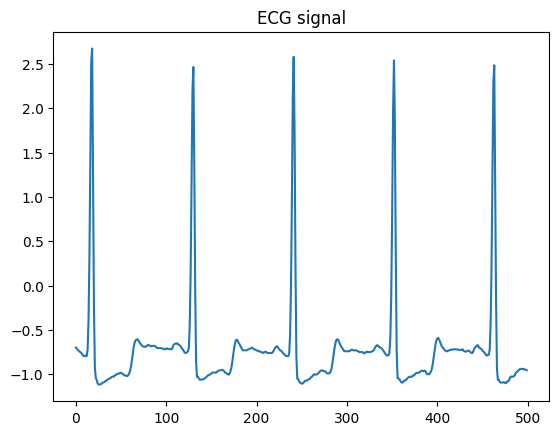

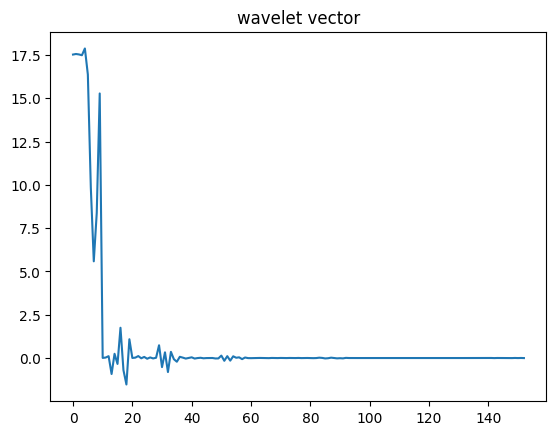

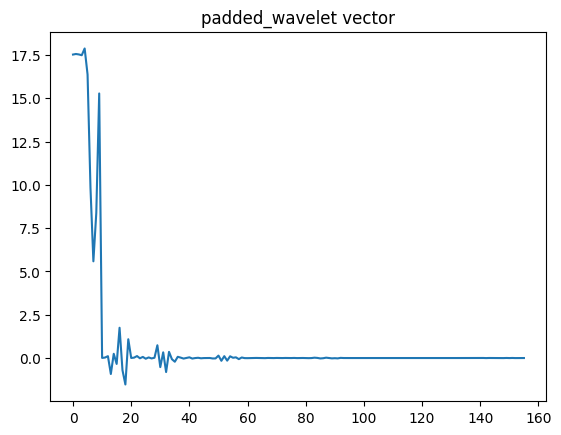

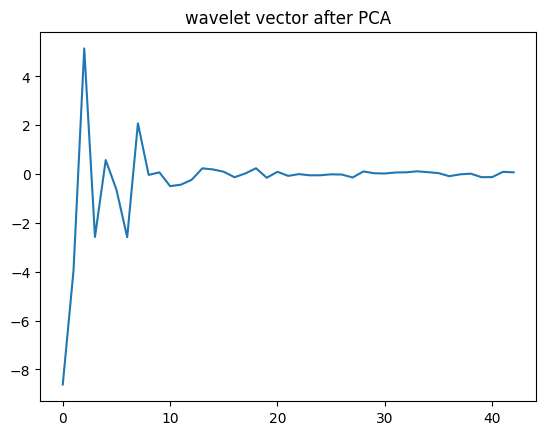

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(PPG_datas[0][:500])), PPG_datas[0][:500])
plt.title('PPG signal')

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(ABP_datas[0][:500])), ABP_datas[0][:500])
plt.title('ABP signal')

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(ECG_datas[0][:500])), ECG_datas[0][:500])
plt.title('ECG signal')

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(wavelet_vectors[0])), wavelet_vectors[0])
plt.title('wavelet vector')

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(padded_wavelet_vectors[0])), padded_wavelet_vectors[0])
plt.title('padded_wavelet vector')

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(pca_wavelet_vectors[0])), pca_wavelet_vectors[0])
plt.title('wavelet vector after PCA')

In [ ]:
def AAMI_standard(predict, test):
    total = len(predict)
    ME = np.mean(predict - test)
    MAE = np.mean(np.abs(predict-test))
    SD = np.std(predict-test)

    return total, ME, MAE, SD

def BHS_standard(predict, test):
    total = len(predict)
    mm5 = np.sum(np.abs(predict-test)<=5)
    mm10 = np.sum(np.abs(predict-test)<=10)
    mm15 = np.sum(np.abs(predict-test)<=15)
    return total, mm5, mm10, mm15

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import GridSearchCV
# parameters = {'max_depth':[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
# clf = GridSearchCV(DecisionTreeRegressor(), parameters)
# clf.fit(x_train, SBP_train)

dtr_SBP = DecisionTreeRegressor(max_depth=10)
print('start fitting...')
dtr_SBP.fit(x_train, SBP_train)
print('finish fitting...')


dtr_DBP = DecisionTreeRegressor(max_depth=10)
print('start fitting...')
dtr_DBP.fit(x_train, DBP_train)
print('finish fitting...')


dtr_MAP = DecisionTreeRegressor(max_depth=10)
print('start fitting...')
dtr_MAP.fit(x_train, MAP_train)
print('finish fitting...')


start fitting...
finish fitting...
start fitting...
finish fitting...
start fitting...
finish fitting...


In [ ]:
import time

# Record the start time
start_time = time.time()


dtr_SBP_predict = dtr_SBP.predict(x_test)
print('finish predicting...')

dtr_DBP_predict = dtr_DBP.predict(x_test)
print('finish predicting...')

dtr_MAP_predict = dtr_MAP.predict(x_test)
print('finish predicting...')


print('Decision Tree Regressor')

total, ME, MAE, SD = AAMI_standard(dtr_SBP_predict, SBP_test)
print()
print()
print('----------------SBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(dtr_SBP_predict, SBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(dtr_DBP_predict, DBP_test)
print()
print()
print('----------------DBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(dtr_DBP_predict, DBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(dtr_MAP_predict, MAP_test)
print()
print()
print('----------------MAP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(dtr_MAP_predict, MAP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print("Time taken:", elapsed_time, "seconds")

finish predicting...
finish predicting...
finish predicting...
Decision Tree Regressor


----------------SBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.046         11.962         16.749          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
6800            11193           13971          19663
34.583%        56.924%       71.052%         19663


----------------DBP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.012         5.685         8.499          19663

-------------BHS standard------------
<5mmHg        <10mmHg        <15mmHg        total
11553            16728           18434          19663
58.755%        85.073%       93.750%         19663


----------------MAP-----------------

-------------AAMI standard----------
ME             MAE             SD           total
0.043         6.513         9.185          19

In [ ]:
print('Decision Tree Regressor')

dtr_SBP_cc= np.corrcoef(dtr_SBP_predict, SBP_test)
dtr_DBP_cc= np.corrcoef(dtr_DBP_predict, DBP_test)
dtr_MAP_cc= np.corrcoef(dtr_MAP_predict, MAP_test)
print()
print()
print('------------Correlation Coefficient-------------')
print()
print('SBP: %.3f' % (dtr_SBP_cc[0, 1]))
print()
print('DBP: %.3f' % (dtr_DBP_cc[0, 1]))
print()
print('MAP: %.3f' % (dtr_MAP_cc[0, 1]))

Decision Tree Regressor


------------Correlation Coefficient-------------

SBP: 0.663

DBP: 0.555

MAP: 0.613


In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
sc_y=StandardScaler()

#from sklearn.svm import LinearSVR
from sklearn.svm import SVR
# from sklearn.model_selection import GridSearchCV
# parameters = {'max_depth':[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
# clf = GridSearchCV(DecisionTreeRegressor(), parameters)
# clf.fit(x_train, SBP_train)

# svr_SBP = LinearSVR(max_iter=10000)
svr_SBP = SVR(kernel='rbf')
print('start fitting...')
svr_SBP.fit(x_train, SBP_train)
print('finish fitting...')


# svr_DBP = LinearSVR(max_iter=10000)
svr_DBP = SVR(kernel='rbf')
print('start fitting...')
svr_DBP.fit(x_train, DBP_train)
print('finish fitting...')


# svr_MAP = LinearSVR(max_iter=10000)
svr_MAP = SVR(kernel='rbf')
print('start fitting...')
svr_MAP.fit(x_train, MAP_train)
print('finish fitting...')


start fitting...
finish fitting...
start fitting...
finish fitting...
start fitting...
finish fitting...


In [ ]:
import time

# Record the start time
start_time = time.time()

svr_SBP_predict = svr_SBP.predict(x_test)
print('finish predicting...')

svr_DBP_predict = svr_DBP.predict(x_test)
print('finish predicting...')

svr_MAP_predict = svr_MAP.predict(x_test)
print('finish predicting...')

print('Support Vector Regression')

total, ME, MAE, SD = AAMI_standard(svr_SBP_predict, SBP_test)
print()
print()
print('----------------SBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(svr_SBP_predict, SBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(svr_DBP_predict, DBP_test)
print()
print()
print('----------------DBP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(svr_DBP_predict, DBP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

total, ME, MAE, SD = AAMI_standard(svr_MAP_predict, MAP_test)
print()
print()
print('----------------MAP-----------------')
print()
print('-------------AAMI standard----------')
print('ME             MAE             SD           total')
print('%.3f         %.3f         %.3f          %d' % (ME,MAE,SD,total))
#print('ME: ', ME, '   MAE: ', MAE, '   SD: ', SD, '   total: ', total)
total, mm5, mm10, mm15 = BHS_standard(svr_MAP_predict, MAP_test)
print()
print('-------------BHS standard------------')
print('<5mmHg        <10mmHg        <15mmHg        total')
print('%d            %d           %d          %d' % (mm5,mm10,mm15,total))
print('%.3f%s        %.3f%s       %.3f%s         %d' % (mm5/total*100, '%',mm10/total*100, '%',mm15/total*100, '%', total))

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print("Time taken:", elapsed_time, "seconds")

In [ ]:
print('Support Vector Regression')

svr_SBP_cc= np.corrcoef(svr_SBP_predict, SBP_test)
svr_DBP_cc= np.corrcoef(svr_DBP_predict, DBP_test)
svr_MAP_cc= np.corrcoef(svr_MAP_predict, MAP_test)
print()
print()
print('------------Correlation Coefficient-------------')
print()
print('SBP: %.3f' % (svr_SBP_cc[0, 1]))
print()
print('DBP: %.3f' % (svr_DBP_cc[0, 1]))
print()
print('MAP: %.3f' % (svr_MAP_cc[0, 1]))